In [1]:
import itertools
import json
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorly as tl

from collections import defaultdict
from glob import glob
from matplotlib import pyplot as plt
from sklearn.decomposition import FastICA, PCA, FactorAnalysis
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MaxAbsScaler
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
from spacy.lang.en import English

nlp = English()
tokenizer = nlp.tokenizer
nlp.add_pipe("sentencizer")

In [3]:
np.random.seed(12345)

# Utility Functionns

## Tree Functions

In [4]:
def get_relations(tree, return_top_node=False):
    if not tree:
        return []
    
    if len(tree['children']) == 0:
        return ('LEAF', []) if return_top_node else []
    
    relations = [tree['name']]
    child_rels = []
    for child in tree['children']:
        child_rel, collected = get_relations(child, True)
        relations += collected
        child_rels.append(child_rel)
    
    relations.append(f"({tree['name']}|{'-'.join(child_rels)})")
        
    return (tree['name'], sorted(set(relations))) if return_top_node else sorted(set(relations))

## Feature Functions

In [5]:
def getWordStats(text):
    '''word count, average length of words'''
    return len(text), np.mean([len(str(w)) for w in text])

def getParagraphStats(text):
    '''number of paragraphs'''
    paras = text.splitlines()
    paras[:] = [element for element in paras if element != '']
    return len(paras)

def getSentenceStats(sents):
    '''number of sentences, average length of sentences, stddev length of sentences'''
    avg_len = np.mean([len(sent) for sent in sents])
    std_dev = np.std([len(sent) for sent in sents])
    
    return len(sents), avg_len, std_dev

In [6]:
def compute_feature_groups(feature_matrix, feature_names, max_end=0.01, diff_threshold=0.005):
    
    #import warnings
    #warnings.simplefilter("ignore")

    print (f'Num. Features: {feature_matrix.shape[1]}')
    
    pca_f = PCA(n_components=0.99)
    pca_f.fit(np.array(feature_matrix))
    
    print (f'Num. Independent Feature Groups: {pca_f.n_components_}')
    
    ica_f = FastICA(n_components=pca_f.n_components_)
    ifm = ica_f.fit_transform(np.array(feature_matrix))
    
    print (f'Independent Feature Matrix Shape: {ifm.shape}')
    
    feature_groups = []
    for i, row in enumerate(np.argsort(np.abs(ica_f.components_), axis=1)):
        #feature_groups.append([feature_names[idx] for idx in row[:-5:-1]])
        last = 1
        group = []
        for feature, value in [(feature_names[idx], ica_f.components_[i, idx]) for idx in row[:-10:-1]]:
            if last - np.abs(value) < diff_threshold and np.abs(value) < max_end:
                break
            f = f"{'NEG_' if value < 0 else 'POS_'}{feature}"
            group.append(f)
            last = np.abs(value)
        feature_groups.append(group)
        
    return ifm, feature_groups

## Visualization Functions

In [7]:
def print_correlated_features(correlation_matrix, feature_groups, threshold, star_threshold, pathway_names=None):
    for i in range(correlation_matrix.shape[1]):
        correlated_features = []
        for j in range(correlation_matrix.shape[0]):
            correlation = np.abs(correlation_matrix[j][i])
            if correlation >= threshold:
                if correlation >= star_threshold:
                    correlated_features.append((j, correlation_matrix[j][i], True, pval_matrix[j][i]))
                else:
                    correlated_features.append((j, correlation_matrix[j][i], False, pval_matrix[j][i]))
        if correlated_features:
            print(f"Pathway Group {i if not pathway_names else pathway_names[i]}: {'may be correlated with model errors' if pval_matrix[0][i] < 0.05 else ''}")
            # ({'r =' if correlation_matrix[0][i] > 0 else 'p >'} {(correlation_matrix[0][i] if correlation_matrix[0][i] > 0 else 0.05):.03f} with error cases)")
            for feature, correlation, is_starred, p_val in correlated_features:
                if is_starred:
                    print(f" * Feature Group {feature}: r = {correlation:.04f} (p={p_val:.02e})")
                else:
                    print(f" - Feature Group {feature}: r = {correlation:.04f} (p={p_val:.02e})")
                    
                for f in feature_groups[feature]:
                    print(f"     -- {f}")
            print()

# Load Common Data

## Word Lists

In [8]:
with open('named_common_clusters.pkl', 'rb') as f:
    word_groups = pickle.load(f)

In [9]:
with open('named_custom_word-lists.pkl', 'rb') as f:
    word_lists = pickle.load(f)

# Experimental Settings

In [10]:
model_options = ['organization', 'main-idea']  #['language', 'main-idea', 'organization', 'support']

In [11]:
is_feature_only = False

# Load Experiment Specific Data

## Align Datasets

In [12]:
datasets = {}
for opt in model_options:
    print(opt)
    datasets[opt] = pd.read_csv(f'{opt}-analysis_set.parsed.csv')
    print (len(datasets[opt]))

organization
775
main-idea
1195


In [13]:
all_ids = set()
for opt in model_options:
    datasets[opt]['_id'] = [hash(s) for s in datasets[opt]['text']]
    if not all_ids:
        print (f"Initializing id set with [{opt}] ... ", end='')
        all_ids.update(set(datasets[opt]['_id']))
        print("DONE.")
    else:
        print (f"Intersecting id set with [{opt}] ... ", end='')
        all_ids = all_ids.intersection(set(datasets[opt]['_id']))
        print("DONE.")
    print (len(all_ids))
    
all_ids = sorted(all_ids)

Initializing id set with [organization] ... DONE.
775
Intersecting id set with [main-idea] ... DONE.
407


In [14]:
len(all_ids)

407

In [15]:
data_idxs = {}
for opt in model_options:
    idx_lst = []
    for idx in all_ids:
        if idx in list(datasets[opt]['_id']):
            idx_lst.append(datasets[opt].index[datasets[opt]['_id'] == idx].tolist()[0])
    data_idxs[opt] = idx_lst
    #data_idxs[opt] = datasets[opt].index[datasets[opt]['_id'].isin(all_ids)].tolist() # This ends up unordered per model

In [16]:
for k, v in data_idxs.items():
    print(k, len(v))

organization 407
main-idea 407


In [17]:
combined_dfs = {}
for opt in data_idxs:
    combined_dfs[opt] = datasets[opt].iloc[data_idxs[opt]]

## Extract all activations for combined sets

In [18]:
activation_matrixes = {}
predictions = {}
actuals = {}
verificaiton = {}

for model_name in model_options:
    print("Model:", model_name)
    all_preds = []
    all_acts = []

    for fname in tqdm(sorted(glob(f'./raw_activations/{model_name}*'))):
        with open(fname, 'rb') as f:
            preds, activations_raw = pickle.load(f)

        set_preds = np.array(preds)[:,0,:]
        concat_acts = []

        for acts in activations_raw:
            concat_acts.append(np.concatenate([h for h in acts]))

        set_activations = np.stack(concat_acts)

        all_preds.append(set_preds)
        all_acts.append(set_activations)
        
    activation_matrix = np.concatenate(all_acts, axis=0)[data_idxs[model_name]]
    print("Activation matrix shape:", activation_matrix.shape)
    
    all_preds =  np.concatenate(all_preds, axis=0)[data_idxs[model_name]]
    pred_values = np.argmax(all_preds, axis=1)
    
    print("Prediction shape:", pred_values.shape)
    
    analysis_set = pd.read_csv(f'{model_name}-analysis_set.parsed.csv')
    
    act_values = np.array(analysis_set[model_name.replace('-', '_')].iloc[data_idxs[model_name]])
    print("Actual shape:", pred_values.shape)
    
    activation_matrixes[model_name] = activation_matrix
    predictions[model_name] = pred_values
    actuals[model_name] = act_values
    verificaiton[model_name] = analysis_set['text'].iloc[data_idxs[model_name]]
    
    print()
    

Model: organization


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 102.91it/s]

Activation matrix shape: (407, 9984)
Prediction shape: (407,)


Actual shape: (407,)

Model: main-idea


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 103.40it/s]

Activation matrix shape: (407, 9984)
Prediction shape: (407,)


Actual shape: (407,)



In [19]:
verified = True

for a, b in zip(verificaiton[model_options[0]], verificaiton[model_options[1]]):
    if a != b:
        verified = False
        print(a, b)
        
print("Data Verified:", verified)

Data Verified: True


## Get combined set for feature extraction

In [20]:
analysis_set = pd.read_csv(f'{model_options[0]}-analysis_set.parsed.csv').iloc[data_idxs[model_options[0]]]

# Feature Extraction

## Extract Tree Features

In [21]:
relation_sets = [get_relations(json.loads(tree)) for tree in analysis_set['tree']]

In [22]:
REL_COUNT_THRESHOLD = 20

relation_count = {}

for relations in relation_sets:
    for rel in relations:
        if rel in relation_count:
            relation_count[rel] += 1
        else:
            relation_count[rel] = 1

all_relations = set()

for relations in relation_sets:
    high_count_rels = [rel for rel in relations if relation_count[rel] >= REL_COUNT_THRESHOLD]
    all_relations.update(high_count_rels)
    
all_relations = sorted(all_relations)
rel2idx = {rel : idx for idx, rel in enumerate(all_relations)}

In [23]:
len(all_relations)

88

In [24]:
relation_matrix = np.zeros((len(relation_sets), len(all_relations)))

for i, rels in enumerate(relation_sets):
    for rel in rels:
        if rel in rel2idx:
            relation_matrix[i, rel2idx[rel]] = 1

In [25]:
relation_matrix.shape

(407, 88)

## Extract Model Performance Features

In [26]:
perf_features = {}

for combination in itertools.combinations_with_replacement(model_options, 2):
    model_a, model_b = combination
    
    if model_a == model_b:
        # This test predicted vs actual
        perf_features[f'diff_{model_a[:4].upper()}_pred-vs-actual'] = ((actuals[model_b] - predictions[model_a]) / 4) ** 2
        
    else:
        # This is difference in predictions from two models
        perf_features[f'diff_{model_a[:4].upper()}-vs-{model_b[:4].upper()}'] = ((predictions[model_b] - predictions[model_a]) / 4) ** 2

In [27]:
perf_df = pd.DataFrame(perf_features)

In [28]:
perf_feature_matrix = np.array(perf_df)
perf_feature_names = list(perf_df.columns)
perf_feature_matrix.shape

(407, 3)

## Extract Word Group Features

### Brown Cluster Word Groups

In [29]:
word_group_features = []

for idx, text in analysis_set['text'].items():
    processed_tokens = [str(t).strip().lower() for t in tokenizer(text) if str(t).strip() != '']
    unique_tokens = sorted(set(processed_tokens))

    counts = defaultdict(int)
    
    for group in word_groups:
        for token in processed_tokens:
            if token in group:
                counts[group] += 1
                
    for group in word_groups:
        counts[group] = counts[group] / len(processed_tokens)
    
    word_group_features.append(list(counts[group] for group in sorted(word_groups)))

In [30]:
word_group_df = pd.DataFrame(word_group_features, columns=sorted(word_groups))

In [31]:
wg_scaler = MaxAbsScaler()
wg_feature_matrix = wg_scaler.fit_transform(word_group_df)
wg_feature_matrix.shape

(407, 22)

In [32]:
word_group_feature_names = ['word-group_' + str(c).replace(' ', '-').replace(',', '') for c in word_group_df.columns]

### Custom Word Lists

In [33]:
word_list_features = []

for idx, text in analysis_set['text'].items():
    tokenized_text = [str(t).strip().lower() for t in tokenizer(text) if str(t).strip() != '']
    processed_tokens = ' ' + ' '.join(tokenized_text) + ' '

    counts = defaultdict(int)
    
    for group in word_lists:
        for word in group:
            counts[group] += processed_tokens.count(' ' + word + ' ')
                
    for group in word_lists:
        counts[group] = counts[group]  / len(tokenized_text)
    
    word_list_features.append(list(counts[group] for group in sorted(word_lists)))

In [34]:
word_list_df = pd.DataFrame(word_list_features, columns=sorted(word_lists))

In [35]:
wl_scaler = MaxAbsScaler()
wl_feature_matrix = wl_scaler.fit_transform(word_list_df)
wl_feature_matrix.shape

(407, 6)

In [36]:
word_list_feature_names = ['word-list_' + str(c).replace(' ', '-').replace(',', '') for c in word_list_df.columns]

## Extract Essay Statistic Features

In [37]:
statistical_features = defaultdict(list)

for idx, text in analysis_set['text'].items():
    processed_text = nlp(text)
    
    wc, awl = getWordStats(processed_text)
    statistical_features['word_count'].append(wc)
    statistical_features['avg_word_length'].append(awl)
    
    pc = getParagraphStats(text)
    statistical_features['paragraph_count'].append(pc)
    
    tokenized_sentences = list(processed_text.sents)
    sc, asl, sdsl = getSentenceStats(tokenized_sentences)
    statistical_features['sentence_count'].append(sc)
    statistical_features['average_sentence_length'].append(asl)
    statistical_features['std_dev_sentence_length'].append(sdsl)

In [38]:
statistical_feature_df = pd.DataFrame(statistical_features)

In [39]:
stat_scaler = MaxAbsScaler()
stat_feature_matrix = stat_scaler.fit_transform(statistical_feature_df)
stat_feature_matrix.shape

(407, 6)

In [40]:
stat_feature_names = list(statistical_feature_df.columns)

## Demographic and School Features

In [41]:
percent_features = [
    'unknown_frac',
    'multi_frac',
    'american_indian_alaska_native_frac',
    'native_hawaiian_or_other_pacific_islander_frac',
    'asian_frac',
    'black_african_american_frac',
    'hispanic_latinx_frac',
    'white_frac',
    'free_or_reduced_price_lunch_frac',
]

In [42]:
numerical_features = [
    'n_students',
    'student_teacher_ratio',
]

In [43]:
categorical_features = [
    'prompt',
    'genre',
    #'has_nslp',
    #'school_name',
    #'district_name',
    'school_type',
    #'is_magnet',
    #'class_name',
    #'grade_level',
    #'state'
]

In [44]:
# Numerical features
sca = MaxAbsScaler()
sca_feature_matrix = sca.fit_transform(analysis_set[numerical_features])

per_feature_matrix = np.array(analysis_set[percent_features])

num_feature_matrix = np.concatenate([per_feature_matrix, sca_feature_matrix], axis=1)
num_feature_names = percent_features + numerical_features

# Categorical features
enc = OneHotEncoder()
cat_feature_matrix = enc.fit_transform(analysis_set[categorical_features]).todense()

cat_feature_names = []
for i, feature in enumerate(categorical_features):
    for j, v in enumerate(enc.categories_[i]):
        cat_feature_names.append(feature + "__" + str(v).replace(' ', '_'))
        
print(num_feature_matrix.shape, cat_feature_matrix.shape)
dem_feature_matrix = np.concatenate([num_feature_matrix, cat_feature_matrix], axis=1)
dem_feature_names = num_feature_names + cat_feature_names
dem_feature_matrix.shape

(407, 11) (407, 12)


(407, 23)

## Combine Feature Matrixes

In [45]:
if is_feature_only:
    feature_matrix = np.concatenate([perf_feature_matrix, wg_feature_matrix, wl_feature_matrix, stat_feature_matrix, dem_feature_matrix, relation_matrix], axis=1)
    feature_names = perf_feature_names + word_group_feature_names + word_list_feature_names + stat_feature_names + dem_feature_names + all_relations
    
    independent_feature_matrix = np.array(feature_matrix)
    feature_groups = [[f] for f in feature_names]
    total_base_features = len(feature_names)

In [46]:
if not is_feature_only:

    feature_matrixes = {
        'Performance Features' : (perf_feature_matrix, perf_feature_names),
        'Brown Cluster Word List Features' : (wg_feature_matrix, word_group_feature_names),
        'Human Curated Word List Features' : (wl_feature_matrix, word_list_feature_names),
        'Statistical Features' : (stat_feature_matrix, stat_feature_names),
        'Demographic/School Features' : (dem_feature_matrix, dem_feature_names),
        'RST Tree Features' : (relation_matrix, all_relations)
    }

    i_feature_matrixes = []
    feature_groups = []
    
    total_base_features = 0

    for n, v in feature_matrixes.items():
        f_matrix, name_list = v
        
        print ()
        print ('*' * 80)
        print (f'Computing independent features from {n} ... ')
        
        total_base_features += len(name_list)
        ifm, fgs = compute_feature_groups(f_matrix, name_list)
        i_feature_matrixes.append(ifm)
        feature_groups.extend(fgs)

    independent_feature_matrix = np.concatenate(i_feature_matrixes, axis=1)
    feature_groups = [sorted(fg, reverse=True) for fg in feature_groups]
    
    print ()
    print ('=' * 80)
    print ('=' * 80)
    print (f'Total Base Features: {total_base_features}')
    print (f'Total Independent Features: {len(feature_groups)}')
    


********************************************************************************
Computing independent features from Performance Features ... 
Num. Features: 3
Num. Independent Feature Groups: 3
Independent Feature Matrix Shape: (407, 3)

********************************************************************************
Computing independent features from Brown Cluster Word List Features ... 
Num. Features: 22
Num. Independent Feature Groups: 12
Independent Feature Matrix Shape: (407, 12)

********************************************************************************
Computing independent features from Human Curated Word List Features ... 
Num. Features: 6
Num. Independent Feature Groups: 2
Independent Feature Matrix Shape: (407, 2)

********************************************************************************
Computing independent features from Statistical Features ... 
Num. Features: 6
Num. Independent Feature Groups: 6
Independent Feature Matrix Shape: (407, 6)

****************

/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:620: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-va

Num. Independent Feature Groups: 80


/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Independent Feature Matrix Shape: (407, 80)

Total Base Features: 148
Total Independent Features: 114


In [47]:
independent_feature_matrix.shape, len(feature_groups)

((407, 114), 114)

# Functional Groups of Functional Components

In [48]:
pathway_models = {}
pathway_matrixes = {}

for model_name in activation_matrixes:
    pca = PCA(n_components=0.95)
    pca.fit(activation_matrixes[model_name])
    
    pathway_models[model_name] = FastICA(n_components=pca.n_components_)
    pathway_matrixes[model_name] = pathway_models[model_name].fit_transform(activation_matrixes[model_name])
    
for model_name in activation_matrixes:
    print(f"Model: {model_name}, Num. Pathways: {pathway_models[model_name].components_.shape[0]}")


/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model: organization, Num. Pathways: 119
Model: main-idea, Num. Pathways: 55


In [49]:
combined_pathways = np.concatenate([pathway_matrixes[m] for m in sorted(pathway_matrixes)], axis=1)
print(f"Combined Shape: {combined_pathways.shape}")

meta_pca = pca = PCA(n_components=0.95)
meta_pca.fit(combined_pathways)

meta_ica = FastICA(n_components=meta_pca.n_components_)
meta_pathway_activations = meta_ica.fit_transform(combined_pathways)
print(f"Reduced Shape: {meta_pathway_activations.shape}")

Combined Shape: (407, 174)


/home/jfiacco/anaconda3/envs/essay_scoring/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Reduced Shape: (407, 125)


In [50]:
pathway_names = []

for model_name in sorted(pathway_matrixes):
    pathway_names.extend([f"{model_name}_{i}" for i in range(pathway_models[model_name].components_.shape[0])])

In [51]:
pathway_groups = []
for i, row in enumerate(np.argsort(np.abs(meta_ica.components_), axis=1)):
    
    #print(row, len(row))
    last = 1
    group = []
    for pathway, value in [(pathway_names[idx], meta_ica.components_[i, idx]) for idx in row[:-10:-1]]:
        if (last - np.abs(value) > 0.3 or np.abs(value) < 0.2) and last != 1:
            break
        f = f"{'NEG_' if value < 0 else 'POS_'}{pathway}"
        #print(f"\t- {f} ({np.abs(value):.03f})")
        f += f"_({np.abs(value):.03f})"
        group.append(f.strip())
        last = np.abs(value)
    if all([any([model_name in g for g in group]) for model_name in model_options]):
        print("Pathway Group", i)
        print(group)
        print()
    pathway_groups.append(group)
    

Pathway Group 4
['POS_organization_92_(0.582)', 'POS_main-idea_29_(0.487)']

Pathway Group 10
['NEG_organization_0_(0.399)', 'NEG_organization_72_(0.370)', 'NEG_organization_41_(0.291)', 'POS_main-idea_45_(0.208)']

Pathway Group 12
['POS_organization_23_(0.615)', 'NEG_main-idea_6_(0.422)']

Pathway Group 13
['POS_main-idea_42_(0.378)', 'NEG_main-idea_6_(0.260)', 'POS_organization_32_(0.258)', 'NEG_main-idea_52_(0.236)', 'NEG_organization_60_(0.206)']

Pathway Group 14
['NEG_organization_25_(0.508)', 'POS_main-idea_20_(0.500)']

Pathway Group 15
['NEG_organization_88_(0.460)', 'NEG_main-idea_13_(0.427)']

Pathway Group 25
['NEG_main-idea_34_(0.375)', 'POS_organization_29_(0.236)', 'NEG_organization_95_(0.224)', 'NEG_organization_104_(0.203)', 'POS_organization_97_(0.202)']

Pathway Group 26
['POS_organization_66_(0.306)', 'NEG_main-idea_15_(0.297)', 'NEG_organization_109_(0.247)', 'POS_organization_99_(0.234)', 'POS_organization_63_(0.205)']

Pathway Group 27
['NEG_organization_72_(0.4

In [52]:
ica_pathways = meta_pathway_activations

# Align Functional Groups with Feature Groups

In [53]:
correlation_matrix = np.zeros((independent_feature_matrix.shape[1], ica_pathways.shape[1]))
pval_matrix = np.zeros((independent_feature_matrix.shape[1], ica_pathways.shape[1]))

for pathway in tqdm(range(ica_pathways.shape[1])):
    for feature in range(independent_feature_matrix.shape[1]):
        r, p = pearsonr(ica_pathways[:, pathway], independent_feature_matrix[:, feature])
        correlation_matrix[feature, pathway] = r if p < 0.05 else 0
        pval_matrix[feature, pathway] = p

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:01<00:00, 78.00it/s]


In [54]:
correlation_matrix.shape

(114, 125)

In [55]:
print_feature_plots = False

if print_feature_plots:
    fig, axes = plt.subplots(nrows=correlation_matrix.shape[0], ncols=1, figsize=(10, 5*pca_f.n_components_))

    feature_groups = []
    for i, row in enumerate(np.argsort(np.abs(ica_f.components_), axis=1)):
        #feature_groups.append([feature_names[idx] for idx in row[:-5:-1]])
        #print("Feature Group", i)
        #for feature, value in [(feature_names[idx], ica_f.components_[i, idx]) for idx in row[:-20:-1]]:
        #    pass #print(feature, value)
        axes[i].plot(range(ica_f.components_.shape[1]), np.abs(ica_f.components_[i][row]))
        axes[i].set_title(f"Feature Group {i}")
        #print()

In [56]:
correlation_matrix.shape

(114, 125)

In [57]:
#print_correlated_features(correlation_matrix, feature_groups, .2, .3, pathway_groups)

# Pathway/Feature Importance

In [58]:
important_pathway_groups = set()

In [59]:
for model_name in model_options:
    print (f'Correlation with prediction -- Model: {model_name}')
    for pathway_group in range(ica_pathways.shape[1]):
        r, p = pearsonr(ica_pathways[:, pathway_group], predictions[model_name])
        if p < 0.05:
            important_pathway_groups.add(pathway_group)
            print(f'\t- Pathway Group {pathway_group:>3}: r = {r:>7.04f} (p<{p:.03f})')
        

Correlation with prediction -- Model: organization
	- Pathway Group   0: r =  0.1264 (p<0.011)
	- Pathway Group   2: r = -0.2187 (p<0.000)
	- Pathway Group   4: r = -0.1273 (p<0.010)
	- Pathway Group  12: r =  0.1712 (p<0.001)
	- Pathway Group  15: r =  0.1547 (p<0.002)
	- Pathway Group  18: r =  0.1140 (p<0.021)
	- Pathway Group  21: r = -0.1254 (p<0.011)
	- Pathway Group  27: r =  0.1389 (p<0.005)
	- Pathway Group  31: r = -0.0977 (p<0.049)
	- Pathway Group  33: r = -0.1206 (p<0.015)
	- Pathway Group  35: r = -0.1159 (p<0.019)
	- Pathway Group  37: r =  0.1385 (p<0.005)
	- Pathway Group  40: r = -0.1098 (p<0.027)
	- Pathway Group  41: r =  0.1217 (p<0.014)
	- Pathway Group  45: r =  0.1077 (p<0.030)
	- Pathway Group  47: r = -0.1312 (p<0.008)
	- Pathway Group  48: r = -0.1152 (p<0.020)
	- Pathway Group  51: r =  0.1542 (p<0.002)
	- Pathway Group  60: r = -0.1239 (p<0.012)
	- Pathway Group  62: r =  0.1111 (p<0.025)
	- Pathway Group  63: r = -0.1008 (p<0.042)
	- Pathway Group  64: r =

In [60]:
for i, comparison in enumerate(perf_feature_names):
    print (f'Correlation with {comparison}')
    for pathway_group in range(ica_pathways.shape[1]):
        r, p = pearsonr(ica_pathways[:, pathway_group], perf_feature_matrix[:, i])
        if p < 0.05:
            important_pathway_groups.add(pathway_group)
            print(f'\t- Pathway Group {pathway_group:>3}: r = {r:>7.04f} (p<{p:.03f})')

Correlation with diff_ORGA_pred-vs-actual
	- Pathway Group  15: r = -0.3859 (p<0.000)
	- Pathway Group  21: r = -0.1093 (p<0.028)
	- Pathway Group  23: r = -0.0993 (p<0.045)
	- Pathway Group  37: r =  0.1185 (p<0.017)
	- Pathway Group  45: r =  0.1024 (p<0.039)
	- Pathway Group  46: r =  0.1152 (p<0.020)
	- Pathway Group  50: r = -0.1078 (p<0.030)
	- Pathway Group  56: r =  0.0975 (p<0.049)
	- Pathway Group  84: r = -0.2331 (p<0.000)
	- Pathway Group  90: r =  0.1001 (p<0.044)
	- Pathway Group  92: r = -0.1155 (p<0.020)
	- Pathway Group  95: r = -0.1491 (p<0.003)
	- Pathway Group  96: r =  0.1556 (p<0.002)
	- Pathway Group 114: r =  0.1188 (p<0.017)
	- Pathway Group 123: r = -0.1786 (p<0.000)
Correlation with diff_ORGA-vs-MAIN
	- Pathway Group   1: r = -0.1020 (p<0.040)
	- Pathway Group   2: r =  0.1678 (p<0.001)
	- Pathway Group   6: r =  0.1241 (p<0.012)
	- Pathway Group   7: r =  0.1112 (p<0.025)
	- Pathway Group  15: r = -0.1191 (p<0.016)
	- Pathway Group  46: r =  0.1497 (p<0.002)

In [61]:
important_pathway_groups = sorted(important_pathway_groups)

# Correlation Graph

In [62]:
protected_features = percent_features

In [63]:
def only_class_0(activation_group):
    return any(model_options[0] in s for s in activation_group) and not any(model_options[1] in s for s in activation_group)

def only_class_1(activation_group):
    return any(model_options[1] in s for s in activation_group) and not any(model_options[0] in s for s in activation_group)

def only_both_classes(activation_group):
    return any(model_options[0] in s for s in activation_group) and any(model_options[1] in s for s in activation_group)


## V3

In [64]:
from IPython.core.magic import Magics, magics_class, line_magic
from matplotlib.colors import LinearSegmentedColormap
import mplcursors
from mplcursors import cursor as mpl_cursor

THRESHOLD = 0.2
OFFSET = 0.5

@magics_class
class GraphMagic(Magics):
    @line_magic
    def graph(self, line):
        args = line.split(";")
        activation_groups = [arg for arg in eval(args[0])]
        feature_groups = [arg for arg in eval(args[1])]
        protected_features = [arg for arg in eval(args[2])]
        correlation_matrix = np.array(eval(args[3]))
        activation_filter_function = eval(args[4])
        fname = eval(args[5])
        important_activation_groups = eval(args[6])

        
        
        cmap = LinearSegmentedColormap.from_list('RWB', [(0, 'red'), (0.5, 'white'), (1, 'blue')])
        

        # Define sorting key function
        def activation_group_key(i):
            # Number of outgoing connections
            n = 1 #num_outgoing[i]
            # Blueness of outgoing connections
            b = sum(c for c in correlation_matrix[i] if np.abs(c) > THRESHOLD)
            return (n, b)
        
        def feature_group_key(i):
            # Blueness of outgoing connections
            b = sum(c for c in correlation_matrix[:,i] if np.abs(c) > THRESHOLD)
            return b

        # Sort activation groups by number and blueness of outgoing connections
        sorted_indices = sorted(range(len(activation_groups)), key=activation_group_key, reverse=True)
        
        # Count the number of outgoing connections for each activation group
        num_outgoing = [0] * len(activation_groups)
        for i in sorted_indices:
            for j, feature_group in enumerate(feature_groups):
                correlation = correlation_matrix[i][j]
                if np.abs(correlation) > THRESHOLD:
                    num_outgoing[i] += 1
        
        # Filter activation groups without outgoing edges
        sorted_indices = [i for i in sorted_indices if num_outgoing[i] > 0 and activation_filter_function(activation_groups[i]) and i in important_activation_groups]
        #sorted_indices = [i for i in sorted_indices if num_outgoing[i] > 0]
        activation_groups = [activation_groups[i] for i in sorted_indices]
        
        if not activation_groups:
            print("No important activations meed the filter condition")
            return
        
        
        sorted_feature_idices = sorted(range(len(feature_groups)), key=feature_group_key, reverse=True)
        
        num_incoming = [0] * len(feature_groups)
        for i in sorted_indices:
            for j in sorted_feature_idices:
                correlation = correlation_matrix[i][j]
                if np.abs(correlation) > THRESHOLD:
                    num_incoming[j] += 1
        
        # Filter feature groups without incoming edges
        sorted_feature_idices = [i for i in sorted_feature_idices if num_incoming[i] > 0]
        feature_groups = [feature_groups[i] for i in sorted_feature_idices]

        max_n = max(len(feature_groups), len(activation_groups))
        
        fig, ax = plt.subplots(figsize=(10, 1 + max_n))
        
        # Draw nodes
        for i, activation_group in enumerate(activation_groups):
            y = max_n * 100 - (i + 0.5) * 100
            
            is_mixed = any([model_options[0] in s for s in activation_group]) and any(model_options[1] in s for s in activation_group)
            if is_mixed:
                fill_color = 'lightgreen'
            elif any([model_options[0] in s for s in activation_group]):
                fill_color = 'khaki'
            else:
                fill_color = 'lightblue'
            
            circle = plt.Circle((50, y), radius=30, fill=True, ec='black', fc=fill_color)
            ax.add_artist(circle)
            ax.text(50, y, sorted_indices[i], ha='center', va='center', fontsize=18)
            mpl_cursor(circle, hover=mplcursors.HoverMode.Transient).connect('add', lambda sel: sel.annotation.set_text(activation_group))
            textbox = ax.text(10, y, str(activation_group), ha='right', va='center', fontsize=12)
            #activation_textboxes.append(textbox)

        for i, feature_group in enumerate(feature_groups):
            y = max_n * 100 - (i + 0.5) * 100
            
            if any(any([f in g for g in feature_group]) for f in protected_features):
                fill = True
            else:
                fill = False
            
            circle = plt.Circle((550, y), radius=30, fill=fill, ec='black', fc='pink')
            ax.add_artist(circle)
            ax.text(550, y, sorted_feature_idices[i], ha='center', va='center', fontsize=18)
            mpl_cursor(circle, hover=mplcursors.HoverMode.Transient).connect('add', lambda sel: sel.annotation.set_text(feature_group))
            textbox = ax.text(590, y, str([s.strip() for s in feature_group]), ha='left', va='center', fontsize=12)

        # Draw edges
        for i, idx, activation_group in zip(range(len(activation_groups)), sorted_indices, activation_groups):
            for j, jdx, feature_group in zip(range(len(feature_groups)), sorted_feature_idices, feature_groups):
                correlation = correlation_matrix[idx][jdx]
                if np.abs(correlation) > THRESHOLD:
                    color = cmap((correlation + 1) / 2)  # scale from [-1, 1] to [0, 1]
                    linewidth = 2 + (abs(correlation) - THRESHOLD) * 30
                    ax.plot([80, 520], [max_n * 100 - (i + 0.5) * 100, max_n * 100 - (j + 0.5) * 100], lw=linewidth, color=color)

        ax.set_xlim([0, 600])
        ax.set_ylim([0, (max(len(activation_groups), len(feature_groups)) + 0.5) * 100])
        ax.axis('off')
        
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        


        
# Register the magic command
ip = get_ipython()
ip.register_magics(GraphMagic)

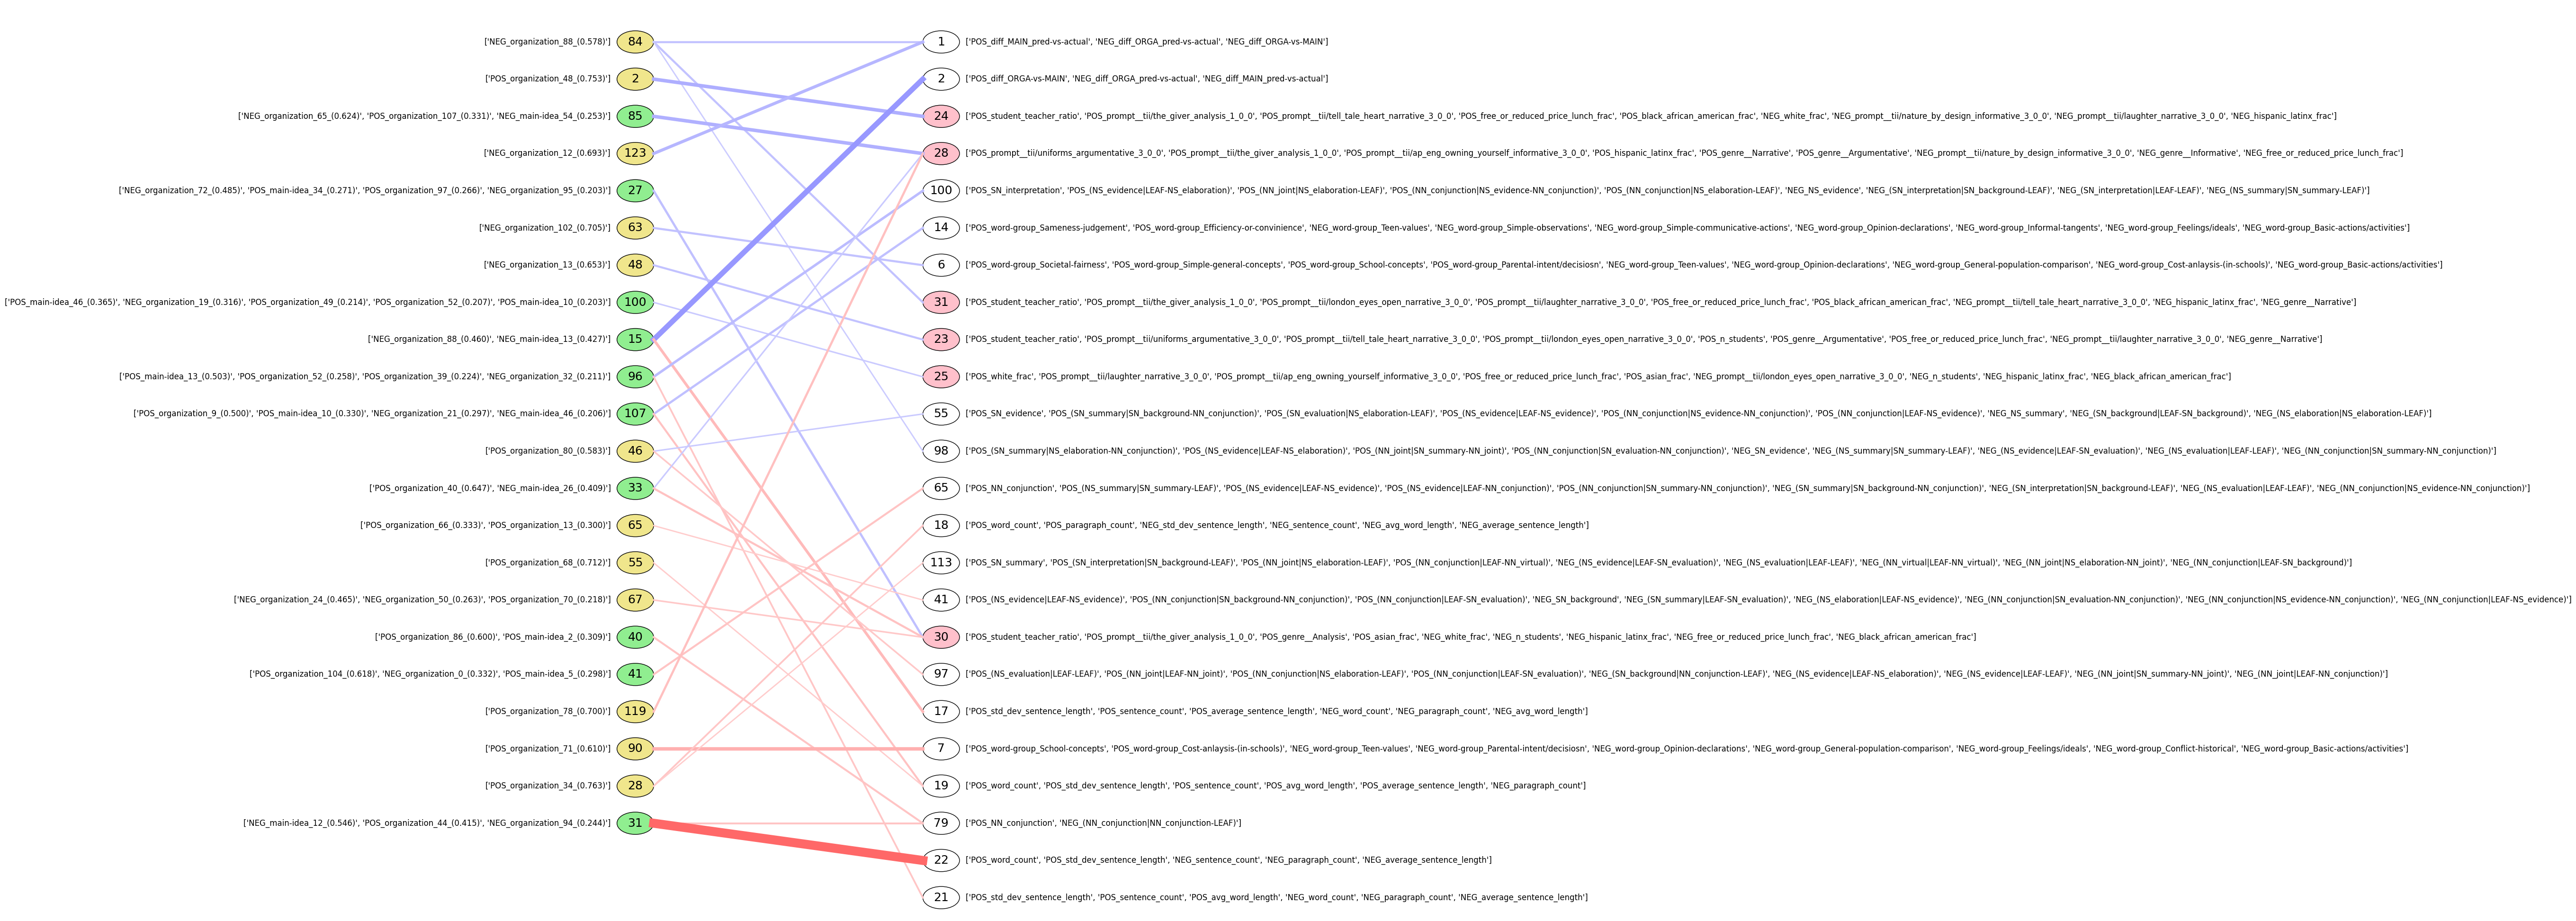

In [65]:
%graph pathway_groups; feature_groups; protected_features; correlation_matrix.T; lambda x: True; f'./results/{model_options[0]}_v_{model_options[1]}.all.feature_groups.png'; important_pathway_groups



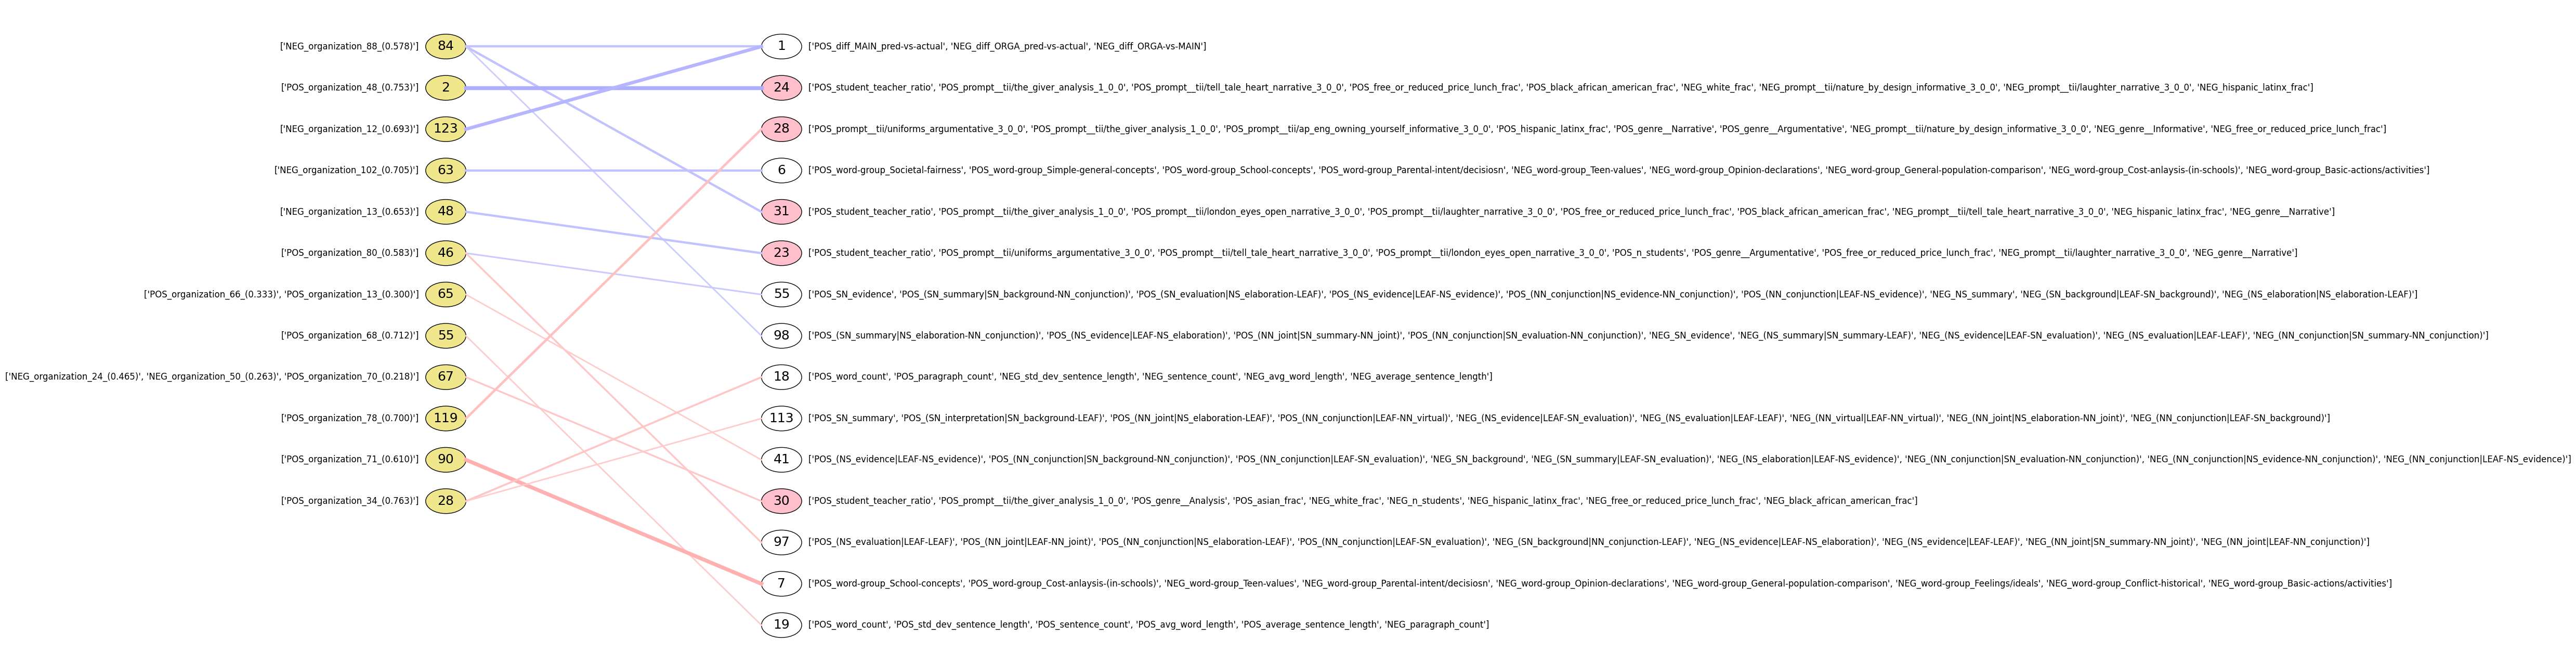

In [66]:
%graph pathway_groups; feature_groups; protected_features; correlation_matrix.T; only_class_0; f'./results/{model_options[0]}_v_{model_options[1]}.ONLY_{model_options[0]}.feature_groups.png'; important_pathway_groups

In [67]:
%graph pathway_groups; feature_groups; protected_features; correlation_matrix.T; only_class_1; f'./results/{model_options[0]}_v_{model_options[1]}.ONLY_{model_options[1]}.feature_groups.png'; important_pathway_groups

No important activations meed the filter condition


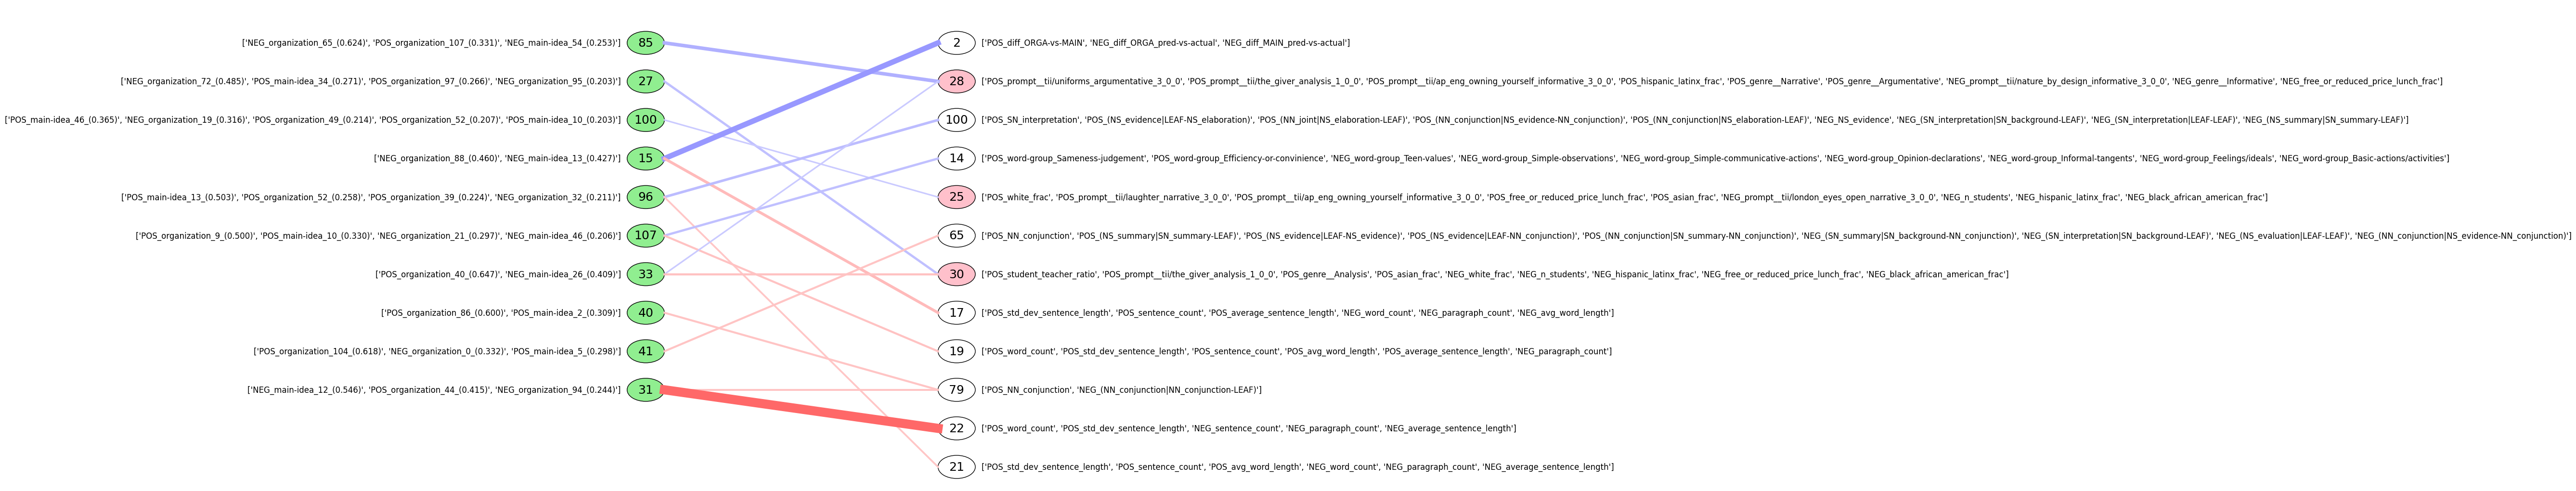

In [68]:
%graph pathway_groups; feature_groups; protected_features; correlation_matrix.T; only_both_classes; f'./results/{model_options[0]}_v_{model_options[1]}.ONLY_mixed.feature_groups.png'; important_pathway_groups

# Save Info

In [69]:
with open(f'./results/{model_options[0]}_v_{model_options[1]}.function_groups.txt', 'w') as f:
    for i, pathway_group in enumerate(pathway_groups):
        
        add_on = []
        for model_name in model_options:
            r, p = pearsonr(ica_pathways[:, i], predictions[model_name])
            if p < 0.05:
                add_on.append(f'Corr. w/ {model_name.upper()}: {r:.03f} (p<{p:.03f})')
                
        for j, comparison in enumerate(perf_feature_names):
            r, p = pearsonr(ica_pathways[:, i], perf_feature_matrix[:, j])
            if p < 0.05:
                add_on.append(f'Corr. w/ {comparison}: {r:.03f} (p<{p:.03f})')
        
        print(f'{"*" if add_on else " "}Functional Component Group: {i}', file=f)
        if add_on:
            for a in add_on:
                print(f'    * {a}', file=f)
        
        for pathway in pathway_group:
            name_tokens = pathway.split('_')
            print(f'    - '
                  f'Loading: {"NEGATIVE" if name_tokens[0] == "NEG" else "POSITIVE"}, '
                  f'Model: {name_tokens[1].upper():>12}, '
                  f'Component ID: {name_tokens[2]:>3}', file=f)
            
        print('', file=f)

In [70]:
with open(f'./results/{model_options[0]}_v_{model_options[1]}.feature_groups.txt', 'w') as f:
    for i, feature_group in enumerate(feature_groups):
        print(f'Feature Group: {i}', file=f)
        
        for feature in feature_group:
            print(f'    - '
                  f'Loading: {"NEGATIVE" if feature[:3] == "NEG" else "POSITIVE"}, '
                  f'Feature Name: {feature[4:]:>3}', file=f)
            
        print('', file=f)

In [71]:
with open(f'./results/{model_options[0]}_v_{model_options[1]}.stats.txt', 'w') as f:
    
    print (f'Num. Data Instances: {len(all_ids)}', file=f)
    print('', file=f)
    
    for model_name in activation_matrixes:
        print(f"Model: {model_name.upper()}, Num. Functional Components: {pathway_models[model_name].components_.shape[0]}", file=f)
        
    print(f"Num. Functional Component Groups: {len(pathway_groups)}", file=f)
    
    print('', file=f)
    print (f'Num. Base Features: {total_base_features}', file=f)
    print (f'Num. Independent Features: {len(feature_groups)}', file=f)
        
        

In [72]:
correlation_matrix.shape

(114, 125)

In [73]:
threshold = THRESHOLD
star_threshold = threshold + 0.1

with open(f'./results/{model_options[0]}_v_{model_options[1]}.correlations.txt', 'w') as f:
    for i in important_pathway_groups:
        correlated_features = []
        for j in range(correlation_matrix.shape[0]):
            correlation = np.abs(correlation_matrix[j][i])
            if correlation > threshold:
                correlated_features.append((j, correlation_matrix[j][i], True, pval_matrix[j][i]))
        if correlated_features:
            print(f"Pathway Group {i}:", file=f)
            for feature, correlation, is_starred, p_val in correlated_features:
                if is_starred:
                    print(f"  * Feature Group {feature}: r = {correlation:.04f} (p={p_val:.02e})", file=f)
                    for feat in feature_groups[feature]:
                        print(f'    - '
                              f'Loading: {"NEGATIVE" if feat[:3] == "NEG" else "POSITIVE"}, '
                              f'Feature Name: {feat[4:]:>3}', file=f)
            print('', file=f)
        

# Exemplar Data

In [74]:
#list(pathway_matrixes)

In [75]:
#N = 5  # Top and bottom N essays
#p = 103  # Pathway of interest
#m = 'organization'  # Model name

## Top N

In [76]:
#top_10_idxs = np.argsort(pathway_matrixes[m], axis=0)[::-1,p][:N]

#print('*' * 80)

#for i, t in enumerate(analysis_set['text'].iloc[top_10_idxs]):
#    print(f"Essay {top_10_idxs[i]} -- Pathway Activation: {pathway_matrixes['organization'][top_10_idxs[i],p]:.03f}")
#    print('-' * 80)
#    print(t.strip())
#    print('*' * 80)

## Bottom N

In [77]:
#bottom_N_idxs = np.argsort(pathway_matrixes[m], axis=0)[::,p][:N]

#print('*' * 80)

#for i, t in enumerate(analysis_set['text'].iloc[bottom_N_idxs]):
#    print(f"Essay {bottom_N_idxs[i]} -- Pathway Activation: {pathway_matrixes['organization'][bottom_N_idxs[i],p]:.03f}")
#    print('-' * 80)
#    print(t.strip())
#    print('*' * 80)

In [78]:
#print_highest_loaded_features(pca_s.components_, mixed_names, .2, 0.3)